In [7]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.6 MB/s eta 0:00:00


In [15]:
import cv2
import matplotlib.pyplot as plt
from insightface.app import FaceAnalysis
from google.colab import files
from PIL import Image
import numpy as np
from PIL import Image
import io

In [18]:
!apt install -y libheif-dev
!pip install pillow pyheif

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libheif-dev is already the newest version (1.12.0-2build1).
libheif-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 71.1 MB/s eta 0:00:00


In [19]:
import pyheif
from PIL import Image, UnidentifiedImageError
from google.colab import files
import io

uploaded = files.upload()

for i, (name, file) in enumerate(uploaded.items(), start=1):
    try:
        if name.lower().endswith(".heic"):
            heif_file = pyheif.read_heif(file)
            img = Image.frombytes(
                heif_file.mode,
                heif_file.size,
                heif_file.data,
                "raw",
                heif_file.mode,
                heif_file.stride,
            ).convert("RGB")
        else:
            img = Image.open(io.BytesIO(file)).convert("RGB")

        new_name = f"face_{i}.jpg"
        img.save(new_name, format="JPEG")
        print(f"✅ Saved {new_name}")

    except Exception as e:
        print(f"❌ Skipped {name}: {e}")

Saving uuid=AA7CE3C2-FA7F-4C36-A69E-48ADF4F364D4&code=001&library=1&type=1&mode=2&loc=true&cap=true.jpeg to uuid=AA7CE3C2-FA7F-4C36-A69E-48ADF4F364D4&code=001&library=1&type=1&mode=2&loc=true&cap=true (1).jpeg
Saving IMG_3249.heic to IMG_3249 (1).heic
✅ Saved face_1.jpg
✅ Saved face_2.jpg


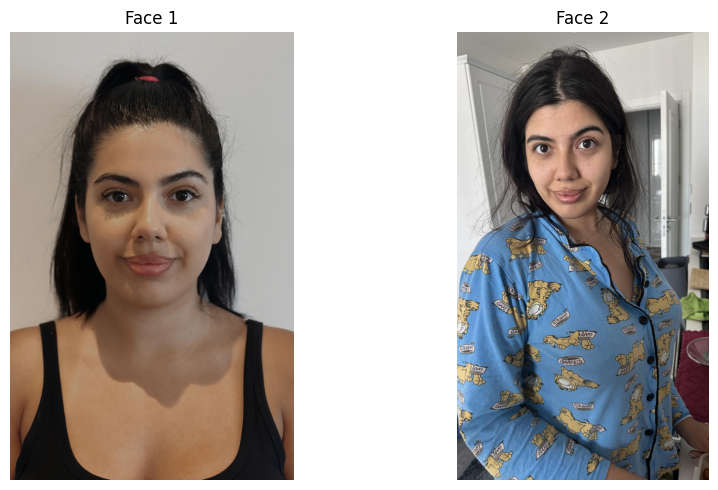

In [20]:
import matplotlib.pyplot as plt
import cv2

# Load renamed uploaded images
img1 = cv2.imread("face_1.jpg")
img2 = cv2.imread("face_2.jpg")

# Convert to RGB for matplotlib
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Display side-by-side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img1_rgb)
plt.title("Face 1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img2_rgb)
plt.title("Face 2")
plt.axis("off")

plt.tight_layout()
plt.show()

In [21]:
! pip install insightface

In [41]:
import insightface
from insightface.app import FaceAnalysis
from insightface.utils import face_align

app = FaceAnalysis(name="buffalo_l", providers=['CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [62]:
def extract_eye_patch(img, eye_kp, size=40):
    x, y = map(int, eye_kp)
    half = size // 2
    return img[y - half:y + half, x - half:x + half]

def get_embedding_from_patch(patch, model):
    face = model.get(patch)
    if face:
        return face[0].embedding.reshape(1, -1)
    return None

In [63]:
from sklearn.metrics.pairwise import cosine_similarity
import cv2
from insightface.utils import face_align

def compare_faces(image_path1, image_path2, model, threshold=0.5, show=True):
    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)

    faces1 = model.get(img1)
    faces2 = model.get(img2)

    if not faces1 or not faces2:
        print("❌ Face not detected in one or both images.")
        return

    # Extract eye patches
    left_eye1 = extract_eye_patch(img1, faces1[0].kps[0])
    left_eye2 = extract_eye_patch(img2, faces2[0].kps[0])
    right_eye1 = extract_eye_patch(img1, faces1[0].kps[1])
    right_eye2 = extract_eye_patch(img2, faces2[0].kps[1])

    # Align faces
    aligned1 = face_align.norm_crop(img1, faces1[0].kps)
    aligned2 = face_align.norm_crop(img2, faces2[0].kps)

    # Get embeddings
    emb_face1 = faces1[0].embedding.reshape(1, -1)
    emb_face2 = faces2[0].embedding.reshape(1, -1)
    face_score = cosine_similarity(emb_face1, emb_face2)[0][0]

    # Eye embeddings
    emb_left1 = get_embedding_from_patch(left_eye1, model)
    emb_left2 = get_embedding_from_patch(left_eye2, model)
    emb_right1 = get_embedding_from_patch(right_eye1, model)
    emb_right2 = get_embedding_from_patch(right_eye2, model)

    if emb_left1 is not None and emb_left2 is not None:
        left_eye_score = cosine_similarity(emb_left1, emb_left2)[0][0]
    else:
        left_eye_score = None

    if emb_right1 is not None and emb_right2 is not None:
        right_eye_score = cosine_similarity(emb_right1, emb_right2)[0][0]
    else:
        right_eye_score = None

    print(f"🧠 Face Similarity:       {face_score:.4f}")
    print(f"👁️  Left Eye Similarity:  {left_eye_score:.4f}" if left_eye_score else "Left eye embedding failed.")
    print(f"👁️  Right Eye Similarity: {right_eye_score:.4f}" if right_eye_score else "Right eye embedding failed.")

    if show:
        # Face display
        aligned1_rgb = cv2.cvtColor(aligned1, cv2.COLOR_BGR2RGB)
        aligned2_rgb = cv2.cvtColor(aligned2, cv2.COLOR_BGR2RGB)
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(aligned1_rgb)
        axs[0].set_title("Face 1")
        axs[0].axis('off')
        axs[1].imshow(aligned2_rgb)
        axs[1].set_title("Face 2")
        axs[1].axis('off')
        plt.suptitle(f"Face Similarity: {face_score:.2f}", fontsize=14)
        plt.tight_layout()
        plt.show()

        # Eye display
        fig2, axs2 = plt.subplots(2, 2, figsize=(6, 6))
        axs2[0, 0].imshow(cv2.cvtColor(left_eye1, cv2.COLOR_BGR2RGB))
        axs2[0, 0].set_title("Left Eye 1")
        axs2[0, 0].axis("off")

        axs2[0, 1].imshow(cv2.cvtColor(left_eye2, cv2.COLOR_BGR2RGB))
        axs2[0, 1].set_title("Left Eye 2")
        axs2[0, 1].axis("off")

        axs2[1, 0].imshow(cv2.cvtColor(right_eye1, cv2.COLOR_BGR2RGB))
        axs2[1, 0].set_title("Right Eye 1")
        axs2[1, 0].axis("off")

        axs2[1, 1].imshow(cv2.cvtColor(right_eye2, cv2.COLOR_BGR2RGB))
        axs2[1, 1].set_title("Right Eye 2")
        axs2[1, 1].axis("off")

        plt.tight_layout()
        plt.show()

    return face_score, left_eye_score, right_eye_score

🧠 Face Similarity:       0.6491
Left eye embedding failed.
Right eye embedding failed.


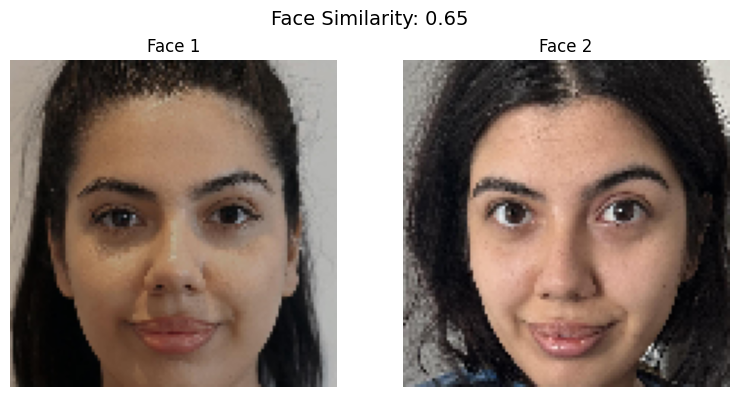

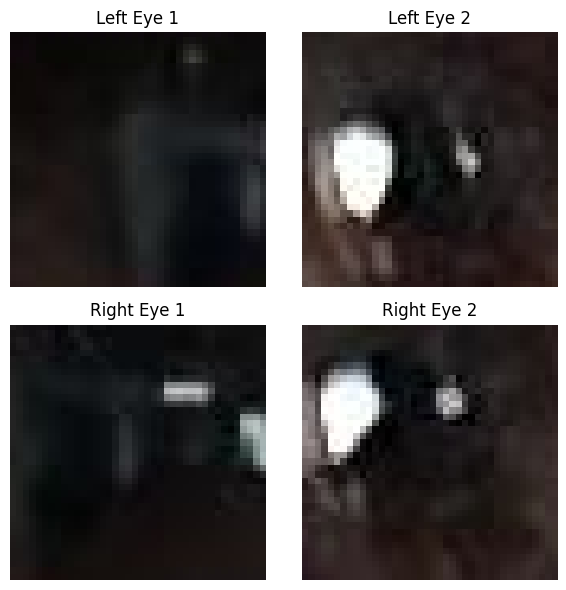

(np.float32(0.6490869), None, None)

In [64]:
compare_faces("face_1.jpg", "face_2.jpg", model=app)

In [65]:
import numpy as np

def eye_similarity(kps1, kps2):
    # kps1 and kps2 are (5, 2) arrays
    left_eye1, right_eye1 = kps1[0], kps1[1]
    left_eye2, right_eye2 = kps2[0], kps2[1]

    left_eye_dist = np.linalg.norm(left_eye1 - left_eye2)
    right_eye_dist = np.linalg.norm(right_eye1 - right_eye2)

    # Optionally: normalize by inter-ocular distance
    norm1 = np.linalg.norm(left_eye1 - right_eye1)
    norm2 = np.linalg.norm(left_eye2 - right_eye2)
    norm = (norm1 + norm2) / 2

    sim_left = 1 - (left_eye_dist / norm)
    sim_right = 1 - (right_eye_dist / norm)

    return sim_left, sim_right

In [66]:
sim_left, sim_right = eye_similarity(faces1[0].kps, faces2[0].kps)
print(f"👁️ Left Eye Similarity:  {sim_left:.4f}")
print(f"👁️ Right Eye Similarity: {sim_right:.4f}")

👁️ Left Eye Similarity:  0.6429
👁️ Right Eye Similarity: 0.5182
